In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import torchmetrics
import timm
import segmentation_models_pytorch as smp
import random
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size=24
image_count=50
img_size=224
tf = ToTensor()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [2]:
train_df = pd.read_csv(
    '../../data/segmentationDDH/train_aug_segmentation_dataset.csv')
val_df = pd.read_csv(
    '../../data/segmentationDDH/val_aug_segmentation_dataset.csv')

train_img_list = train_df['file name'].to_list()
train_label_list = train_df['standard mask'].to_list()
train_case_list = train_df['case'].to_list()
train_img_path = '../../data/segmentationDDH/aug_dataset/train/'
val_img_list = val_df['file name'].to_list()
val_label_list = val_df['standard mask'].to_list()
val_case_list = val_df['case'].to_list()
val_img_path = '../../data/segmentationDDH/aug_dataset/val/'

val_image=torch.zeros((len(val_img_list),3,img_size,img_size))
val_mask=torch.zeros((len(val_img_list),3,img_size,img_size),dtype=torch.uint8)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),3,img_size,img_size),dtype=torch.uint8)

for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(np.array(Image.open(
        train_img_path+str(train_case_list[i])+'/image/'+train_img_list[i]).resize((img_size, img_size))))
    train_mask[i,1]=tf(np.array(Image.open(
        train_img_path+str(train_case_list[i])+'/mask/'+str(train_label_list[i]).zfill(5)+'/1'+train_img_list[i][train_img_list[i].find('_'):]).resize((img_size, img_size))))
    train_mask[i,2]=tf(np.array(Image.open(
        train_img_path+str(train_case_list[i])+'/mask/'+str(train_label_list[i]).zfill(5)+'/2'+train_img_list[i][train_img_list[i].find('_'):]).resize((img_size, img_size))))
    train_mask[i,0]=torch.where((train_mask[i,1]+train_mask[i,2])==0,1,0)
    

for i in tqdm(range(len(val_img_list))):
    val_image[i] = tf(np.array(Image.open(
        val_img_path+str(val_case_list[i])+'/image/'+val_img_list[i]).resize((img_size, img_size))))
    val_mask[i,1]=tf(np.array(Image.open(
        val_img_path+str(val_case_list[i])+'/mask/'+str(val_label_list[i]).zfill(5)+'/1.png').resize((img_size, img_size))))
    val_mask[i,2]=tf(np.array(Image.open(
        val_img_path+str(val_case_list[i])+'/mask/'+str(val_label_list[i]).zfill(5)+'/2.png').resize((img_size, img_size))))
    val_mask[i,0]=torch.where((val_mask[i,1]+val_mask[i,2])==0,1,0)



  1%|          | 169/20364 [00:04<09:35, 35.10it/s]


KeyboardInterrupt: 

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path = self.img_path[idx]
        label_path =  self.label[idx]
        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

val_dataset = CustomDataset(val_image, val_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
model=smp.UnetPlusPlus('mobilenet_v2', in_channels=3, classes=3).to(device)
summary(model,(batch_size,3,img_size,img_size))
def dice_loss(pred, target, num_classes=3):
    smooth = 1.
    dice_per_class = torch.zeros(num_classes).to(pred.device)
    
    for class_id in range(num_classes):
        pred_class = pred[:, class_id, ...]
        target_class = target[:, class_id, ...]

        intersection = torch.sum(pred_class * target_class)
        A_sum = torch.sum(pred_class * pred_class)
        B_sum = torch.sum(target_class * target_class)

        dice_per_class[class_id] = 1 - (2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return torch.mean(dice_per_class)



epoch: 1/300 Step: 849 dice_loss : 0.2771 dice_score: 0.7229: 100%|██████████| 848/848 [01:46<00:00,  7.98it/s]
Validation epoch: 1/300 Step: 20 dice_loss : 0.2355  dice_score: 0.7645: 100%|██████████| 19/19 [00:00<00:00, 22.48it/s]
epoch: 2/300 Step: 849 dice_loss : 0.1039 dice_score: 0.8961: 100%|██████████| 848/848 [01:34<00:00,  8.98it/s]
Validation epoch: 2/300 Step: 20 dice_loss : 0.1426  dice_score: 0.8574: 100%|██████████| 19/19 [00:00<00:00, 23.31it/s]
epoch: 3/300 Step: 849 dice_loss : 0.0900 dice_score: 0.9100: 100%|██████████| 848/848 [01:34<00:00,  9.01it/s]
Validation epoch: 3/300 Step: 20 dice_loss : 0.1497  dice_score: 0.8503: 100%|██████████| 19/19 [00:00<00:00, 23.48it/s]
epoch: 4/300 Step: 849 dice_loss : 0.0819 dice_score: 0.9181: 100%|██████████| 848/848 [01:32<00:00,  9.13it/s]
Validation epoch: 4/300 Step: 20 dice_loss : 0.1443  dice_score: 0.8557: 100%|██████████| 19/19 [00:00<00:00, 23.37it/s]
epoch: 5/300 Step: 849 dice_loss : 0.0761 dice_score: 0.9239: 100%|█

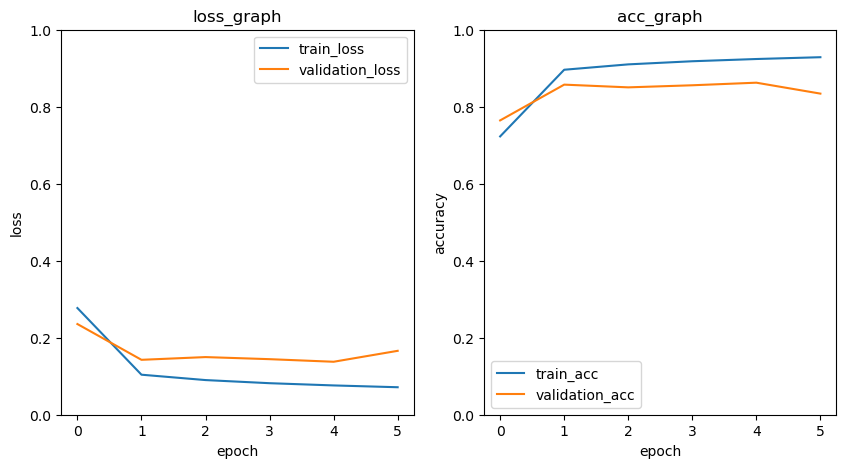

epoch: 7/300 Step: 849 dice_loss : 0.0676 dice_score: 0.9324: 100%|██████████| 848/848 [01:33<00:00,  9.07it/s]
Validation epoch: 7/300 Step: 20 dice_loss : 0.1560  dice_score: 0.8440: 100%|██████████| 19/19 [00:00<00:00, 22.77it/s]
epoch: 8/300 Step: 849 dice_loss : 0.0641 dice_score: 0.9359: 100%|██████████| 848/848 [01:34<00:00,  9.02it/s]
Validation epoch: 8/300 Step: 20 dice_loss : 0.1420  dice_score: 0.8580: 100%|██████████| 19/19 [00:00<00:00, 23.27it/s]
epoch: 9/300 Step: 849 dice_loss : 0.0615 dice_score: 0.9385: 100%|██████████| 848/848 [01:33<00:00,  9.04it/s]
Validation epoch: 9/300 Step: 20 dice_loss : 0.1600  dice_score: 0.8400: 100%|██████████| 19/19 [00:00<00:00, 22.08it/s]
epoch: 10/300 Step: 849 dice_loss : 0.0587 dice_score: 0.9413: 100%|██████████| 848/848 [01:34<00:00,  9.02it/s]
Validation epoch: 10/300 Step: 20 dice_loss : 0.1548  dice_score: 0.8452: 100%|██████████| 19/19 [00:00<00:00, 23.28it/s]
epoch: 11/300 Step: 849 dice_loss : 0.0564 dice_score: 0.9436: 100

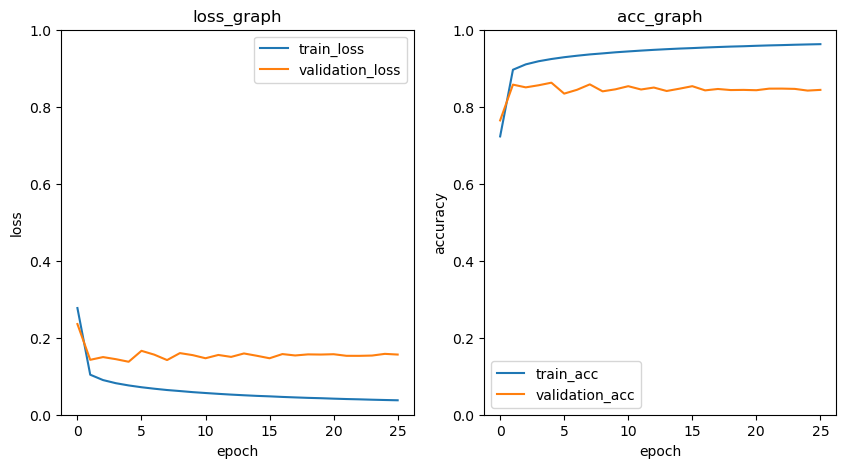

epoch: 27/300 Step: 849 dice_loss : 0.0368 dice_score: 0.9632: 100%|██████████| 848/848 [01:34<00:00,  9.02it/s]
Validation epoch: 27/300 Step: 20 dice_loss : 0.1597  dice_score: 0.8403: 100%|██████████| 19/19 [00:00<00:00, 22.32it/s]
epoch: 28/300 Step: 849 dice_loss : 0.0362 dice_score: 0.9638: 100%|██████████| 848/848 [01:33<00:00,  9.04it/s]
Validation epoch: 28/300 Step: 20 dice_loss : 0.1553  dice_score: 0.8447: 100%|██████████| 19/19 [00:00<00:00, 21.49it/s]
epoch: 29/300 Step: 849 dice_loss : 0.0354 dice_score: 0.9646: 100%|██████████| 848/848 [01:33<00:00,  9.09it/s]
Validation epoch: 29/300 Step: 20 dice_loss : 0.1587  dice_score: 0.8413: 100%|██████████| 19/19 [00:00<00:00, 22.80it/s]
epoch: 30/300 Step: 849 dice_loss : 0.0349 dice_score: 0.9651: 100%|██████████| 848/848 [01:33<00:00,  9.04it/s]
Validation epoch: 30/300 Step: 20 dice_loss : 0.1605  dice_score: 0.8395: 100%|██████████| 19/19 [00:00<00:00, 22.71it/s]
epoch: 31/300 Step: 849 dice_loss : 0.0343 dice_score: 0.965

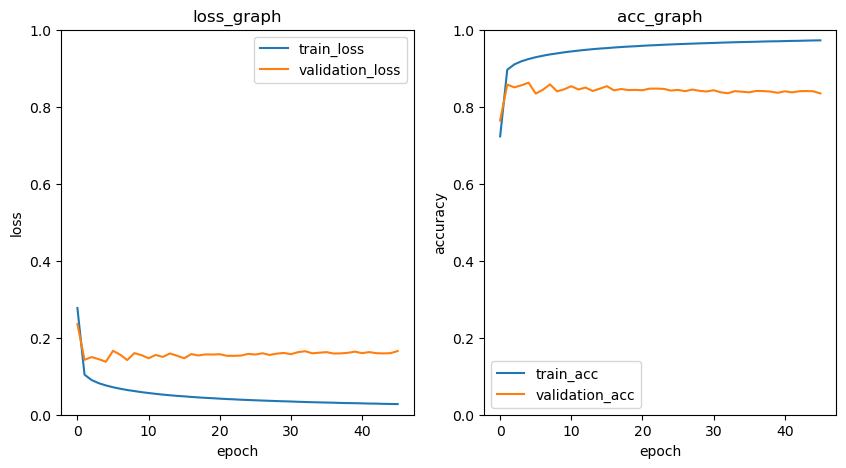

epoch: 47/300 Step: 849 dice_loss : 0.0276 dice_score: 0.9724: 100%|██████████| 848/848 [01:35<00:00,  8.92it/s]
Validation epoch: 47/300 Step: 20 dice_loss : 0.1615  dice_score: 0.8385: 100%|██████████| 19/19 [00:00<00:00, 22.44it/s]
epoch: 48/300 Step: 849 dice_loss : 0.0272 dice_score: 0.9728: 100%|██████████| 848/848 [01:35<00:00,  8.89it/s]
Validation epoch: 48/300 Step: 20 dice_loss : 0.1606  dice_score: 0.8394: 100%|██████████| 19/19 [00:00<00:00, 21.76it/s]
epoch: 49/300 Step: 849 dice_loss : 0.0266 dice_score: 0.9734: 100%|██████████| 848/848 [01:34<00:00,  8.95it/s]
Validation epoch: 49/300 Step: 20 dice_loss : 0.1593  dice_score: 0.8407: 100%|██████████| 19/19 [00:00<00:00, 21.03it/s]
epoch: 50/300 Step: 849 dice_loss : 0.0264 dice_score: 0.9736: 100%|██████████| 848/848 [01:35<00:00,  8.88it/s]
Validation epoch: 50/300 Step: 20 dice_loss : 0.1616  dice_score: 0.8384: 100%|██████████| 19/19 [00:00<00:00, 21.92it/s]
epoch: 51/300 Step: 849 dice_loss : 0.0262 dice_score: 0.973

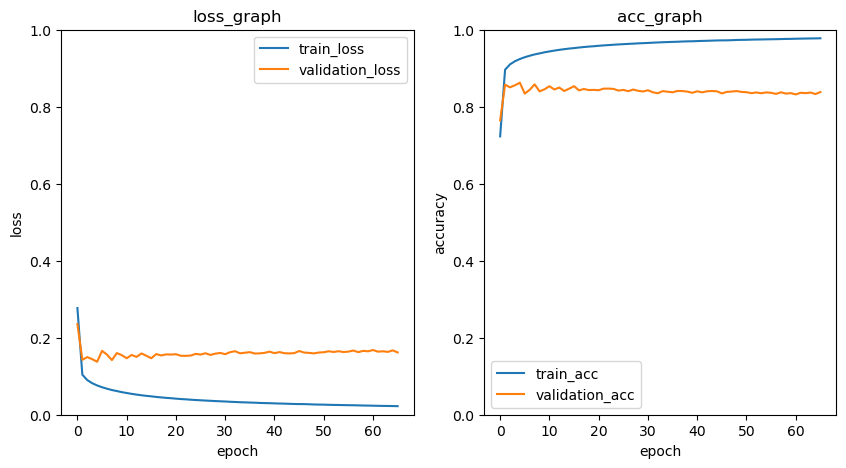

epoch: 67/300 Step: 849 dice_loss : 0.0221 dice_score: 0.9779: 100%|██████████| 848/848 [01:35<00:00,  8.85it/s]
Validation epoch: 67/300 Step: 20 dice_loss : 0.1642  dice_score: 0.8358: 100%|██████████| 19/19 [00:00<00:00, 22.46it/s]
epoch: 68/300 Step: 849 dice_loss : 0.0218 dice_score: 0.9782: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 68/300 Step: 20 dice_loss : 0.1641  dice_score: 0.8359: 100%|██████████| 19/19 [00:00<00:00, 20.93it/s]
epoch: 69/300 Step: 849 dice_loss : 0.0217 dice_score: 0.9783: 100%|██████████| 848/848 [01:35<00:00,  8.85it/s]
Validation epoch: 69/300 Step: 20 dice_loss : 0.1644  dice_score: 0.8356: 100%|██████████| 19/19 [00:00<00:00, 20.38it/s]
epoch: 70/300 Step: 849 dice_loss : 0.0215 dice_score: 0.9785: 100%|██████████| 848/848 [01:35<00:00,  8.87it/s]
Validation epoch: 70/300 Step: 20 dice_loss : 0.1649  dice_score: 0.8351: 100%|██████████| 19/19 [00:00<00:00, 20.35it/s]
epoch: 71/300 Step: 849 dice_loss : 0.0214 dice_score: 0.978

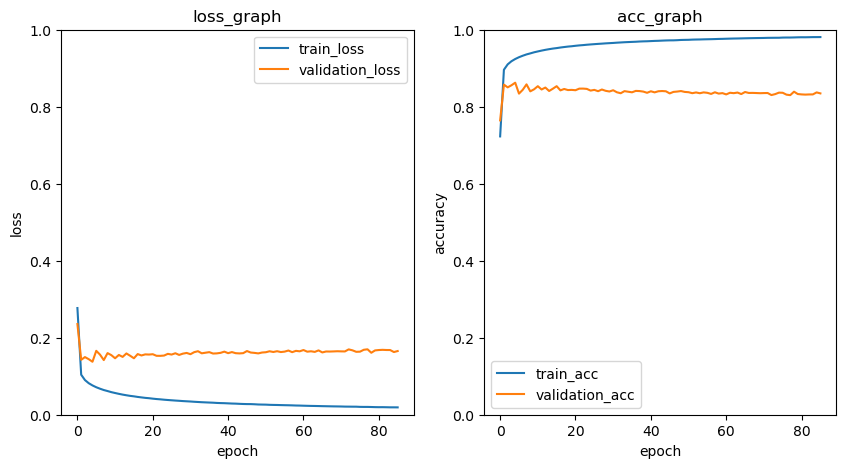

epoch: 87/300 Step: 849 dice_loss : 0.0188 dice_score: 0.9812: 100%|██████████| 848/848 [01:36<00:00,  8.83it/s]
Validation epoch: 87/300 Step: 20 dice_loss : 0.1646  dice_score: 0.8354: 100%|██████████| 19/19 [00:00<00:00, 21.15it/s]
epoch: 88/300 Step: 849 dice_loss : 0.0188 dice_score: 0.9812: 100%|██████████| 848/848 [01:35<00:00,  8.84it/s]
Validation epoch: 88/300 Step: 20 dice_loss : 0.1689  dice_score: 0.8311: 100%|██████████| 19/19 [00:00<00:00, 22.73it/s]
epoch: 89/300 Step: 849 dice_loss : 0.0186 dice_score: 0.9814: 100%|██████████| 848/848 [01:36<00:00,  8.82it/s]
Validation epoch: 89/300 Step: 20 dice_loss : 0.1637  dice_score: 0.8363: 100%|██████████| 19/19 [00:00<00:00, 20.25it/s]
epoch: 90/300 Step: 849 dice_loss : 0.0184 dice_score: 0.9816: 100%|██████████| 848/848 [01:35<00:00,  8.84it/s]
Validation epoch: 90/300 Step: 20 dice_loss : 0.1631  dice_score: 0.8369: 100%|██████████| 19/19 [00:00<00:00, 21.95it/s]
epoch: 91/300 Step: 849 dice_loss : 0.0183 dice_score: 0.981

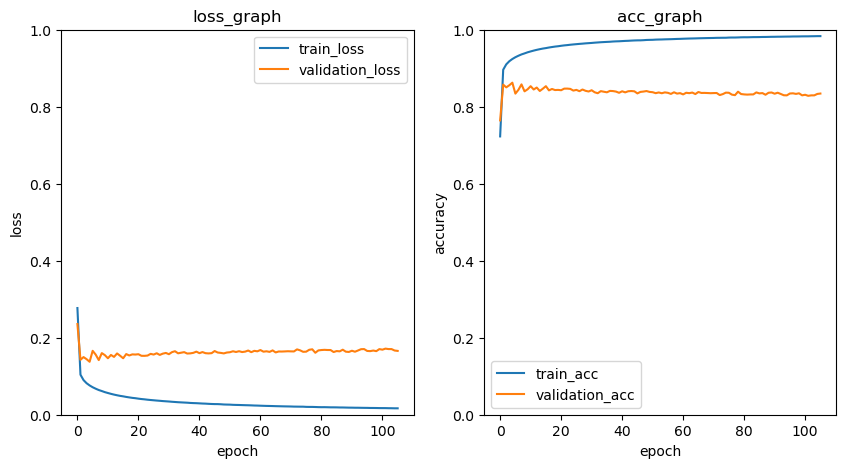

epoch: 107/300 Step: 849 dice_loss : 0.0166 dice_score: 0.9834: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 107/300 Step: 20 dice_loss : 0.1667  dice_score: 0.8333: 100%|██████████| 19/19 [00:00<00:00, 22.09it/s]
epoch: 108/300 Step: 849 dice_loss : 0.0165 dice_score: 0.9835: 100%|██████████| 848/848 [01:35<00:00,  8.88it/s]
Validation epoch: 108/300 Step: 20 dice_loss : 0.1647  dice_score: 0.8353: 100%|██████████| 19/19 [00:00<00:00, 21.25it/s]
epoch: 109/300 Step: 849 dice_loss : 0.0164 dice_score: 0.9836: 100%|██████████| 848/848 [01:36<00:00,  8.83it/s]
Validation epoch: 109/300 Step: 20 dice_loss : 0.1683  dice_score: 0.8317: 100%|██████████| 19/19 [00:00<00:00, 21.74it/s]
epoch: 110/300 Step: 849 dice_loss : 0.0163 dice_score: 0.9837: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 110/300 Step: 20 dice_loss : 0.1687  dice_score: 0.8313: 100%|██████████| 19/19 [00:00<00:00, 20.45it/s]
epoch: 111/300 Step: 849 dice_loss : 0.0162 dice_sco

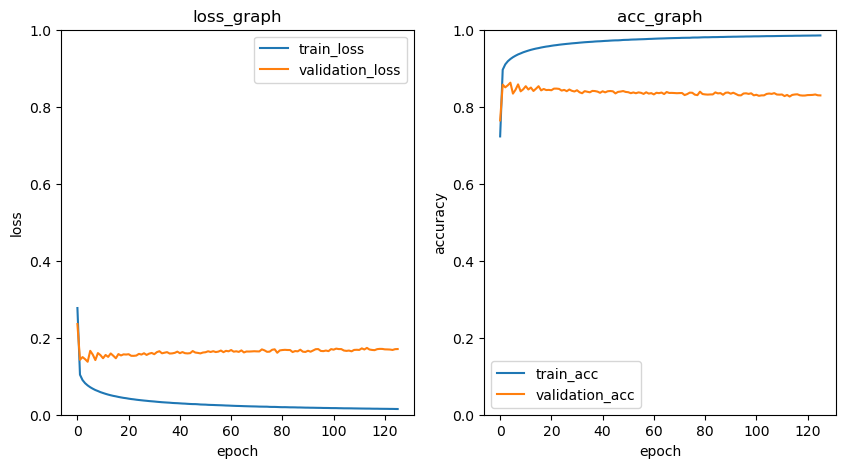

epoch: 127/300 Step: 849 dice_loss : 0.0149 dice_score: 0.9851: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 127/300 Step: 20 dice_loss : 0.1694  dice_score: 0.8306: 100%|██████████| 19/19 [00:00<00:00, 21.34it/s]
epoch: 128/300 Step: 849 dice_loss : 0.0147 dice_score: 0.9853: 100%|██████████| 848/848 [01:35<00:00,  8.93it/s]
Validation epoch: 128/300 Step: 20 dice_loss : 0.1710  dice_score: 0.8290: 100%|██████████| 19/19 [00:00<00:00, 20.93it/s]
epoch: 129/300 Step: 849 dice_loss : 0.0148 dice_score: 0.9852: 100%|██████████| 848/848 [01:34<00:00,  8.95it/s]
Validation epoch: 129/300 Step: 20 dice_loss : 0.1695  dice_score: 0.8305: 100%|██████████| 19/19 [00:00<00:00, 21.07it/s]
epoch: 130/300 Step: 849 dice_loss : 0.0146 dice_score: 0.9854: 100%|██████████| 848/848 [01:35<00:00,  8.89it/s]
Validation epoch: 130/300 Step: 20 dice_loss : 0.1689  dice_score: 0.8311: 100%|██████████| 19/19 [00:00<00:00, 21.38it/s]
epoch: 131/300 Step: 849 dice_loss : 0.0145 dice_sco

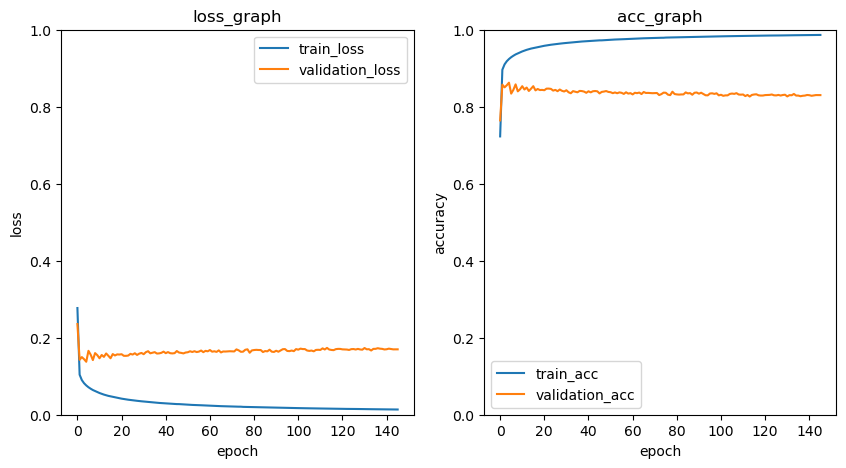

epoch: 147/300 Step: 849 dice_loss : 0.0135 dice_score: 0.9865: 100%|██████████| 848/848 [01:35<00:00,  8.93it/s]
Validation epoch: 147/300 Step: 20 dice_loss : 0.1761  dice_score: 0.8239: 100%|██████████| 19/19 [00:00<00:00, 22.28it/s]
epoch: 148/300 Step: 849 dice_loss : 0.0135 dice_score: 0.9865: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 148/300 Step: 20 dice_loss : 0.1716  dice_score: 0.8284: 100%|██████████| 19/19 [00:00<00:00, 21.58it/s]
epoch: 149/300 Step: 849 dice_loss : 0.0134 dice_score: 0.9866: 100%|██████████| 848/848 [01:35<00:00,  8.87it/s]
Validation epoch: 149/300 Step: 20 dice_loss : 0.1708  dice_score: 0.8292: 100%|██████████| 19/19 [00:00<00:00, 20.70it/s]
epoch: 150/300 Step: 849 dice_loss : 0.0134 dice_score: 0.9866: 100%|██████████| 848/848 [01:35<00:00,  8.87it/s]
Validation epoch: 150/300 Step: 20 dice_loss : 0.1721  dice_score: 0.8279: 100%|██████████| 19/19 [00:00<00:00, 21.26it/s]
epoch: 151/300 Step: 849 dice_loss : 0.0133 dice_sco

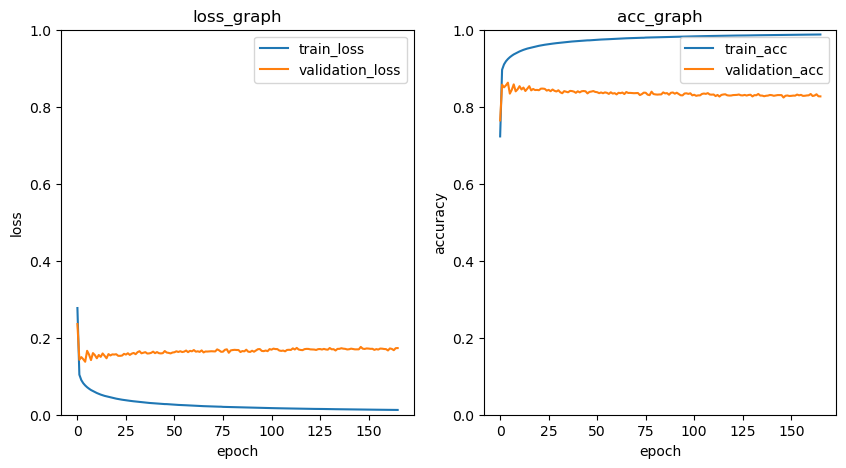

epoch: 167/300 Step: 849 dice_loss : 0.0124 dice_score: 0.9876: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 167/300 Step: 20 dice_loss : 0.1689  dice_score: 0.8311: 100%|██████████| 19/19 [00:00<00:00, 21.71it/s]
epoch: 168/300 Step: 849 dice_loss : 0.0123 dice_score: 0.9877: 100%|██████████| 848/848 [01:35<00:00,  8.84it/s]
Validation epoch: 168/300 Step: 20 dice_loss : 0.1697  dice_score: 0.8303: 100%|██████████| 19/19 [00:00<00:00, 21.93it/s]
epoch: 169/300 Step: 849 dice_loss : 0.0122 dice_score: 0.9878: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 169/300 Step: 20 dice_loss : 0.1701  dice_score: 0.8299: 100%|██████████| 19/19 [00:00<00:00, 22.38it/s]
epoch: 170/300 Step: 849 dice_loss : 0.0123 dice_score: 0.9877: 100%|██████████| 848/848 [01:35<00:00,  8.89it/s]
Validation epoch: 170/300 Step: 20 dice_loss : 0.1694  dice_score: 0.8306: 100%|██████████| 19/19 [00:00<00:00, 20.92it/s]
epoch: 171/300 Step: 849 dice_loss : 0.0122 dice_sco

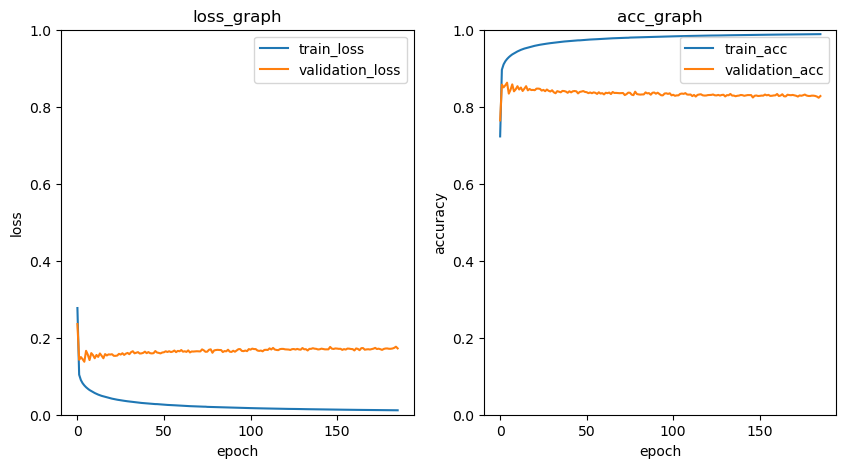

epoch: 187/300 Step: 849 dice_loss : 0.0114 dice_score: 0.9886: 100%|██████████| 848/848 [01:34<00:00,  8.93it/s]
Validation epoch: 187/300 Step: 20 dice_loss : 0.1730  dice_score: 0.8270: 100%|██████████| 19/19 [00:00<00:00, 21.74it/s]
epoch: 188/300 Step: 849 dice_loss : 0.0115 dice_score: 0.9885: 100%|██████████| 848/848 [01:34<00:00,  8.99it/s]
Validation epoch: 188/300 Step: 20 dice_loss : 0.1726  dice_score: 0.8274: 100%|██████████| 19/19 [00:00<00:00, 22.23it/s]
epoch: 189/300 Step: 849 dice_loss : 0.0114 dice_score: 0.9886: 100%|██████████| 848/848 [01:34<00:00,  8.95it/s]
Validation epoch: 189/300 Step: 20 dice_loss : 0.1702  dice_score: 0.8298: 100%|██████████| 19/19 [00:00<00:00, 21.67it/s]
epoch: 190/300 Step: 849 dice_loss : 0.0113 dice_score: 0.9887: 100%|██████████| 848/848 [01:35<00:00,  8.89it/s]
Validation epoch: 190/300 Step: 20 dice_loss : 0.1685  dice_score: 0.8315: 100%|██████████| 19/19 [00:00<00:00, 21.76it/s]
epoch: 191/300 Step: 849 dice_loss : 0.0113 dice_sco

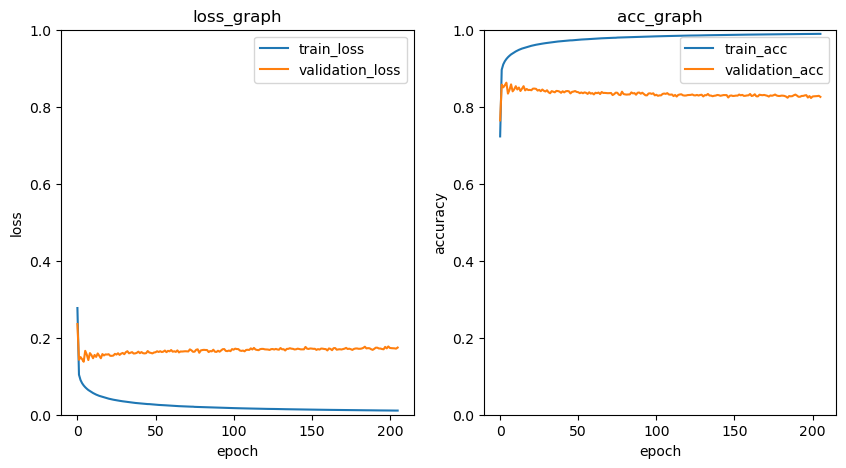

epoch: 207/300 Step: 849 dice_loss : 0.0107 dice_score: 0.9893: 100%|██████████| 848/848 [01:34<00:00,  8.94it/s]
Validation epoch: 207/300 Step: 20 dice_loss : 0.1730  dice_score: 0.8270: 100%|██████████| 19/19 [00:00<00:00, 22.57it/s]
epoch: 208/300 Step: 849 dice_loss : 0.0107 dice_score: 0.9893: 100%|██████████| 848/848 [01:35<00:00,  8.92it/s]
Validation epoch: 208/300 Step: 20 dice_loss : 0.1713  dice_score: 0.8287: 100%|██████████| 19/19 [00:00<00:00, 20.69it/s]
epoch: 209/300 Step: 849 dice_loss : 0.0106 dice_score: 0.9894: 100%|██████████| 848/848 [01:35<00:00,  8.84it/s]
Validation epoch: 209/300 Step: 20 dice_loss : 0.1751  dice_score: 0.8249: 100%|██████████| 19/19 [00:00<00:00, 22.89it/s]
epoch: 210/300 Step: 849 dice_loss : 0.0106 dice_score: 0.9894: 100%|██████████| 848/848 [01:34<00:00,  8.94it/s]
Validation epoch: 210/300 Step: 20 dice_loss : 0.1712  dice_score: 0.8288: 100%|██████████| 19/19 [00:00<00:00, 21.43it/s]
epoch: 211/300 Step: 849 dice_loss : 0.0105 dice_sco

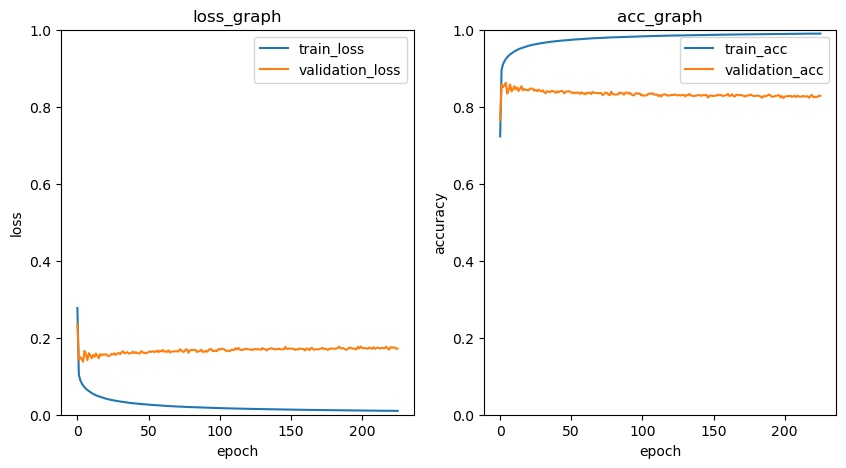

epoch: 227/300 Step: 849 dice_loss : 0.0100 dice_score: 0.9900: 100%|██████████| 848/848 [01:35<00:00,  8.91it/s]
Validation epoch: 227/300 Step: 20 dice_loss : 0.1777  dice_score: 0.8223: 100%|██████████| 19/19 [00:00<00:00, 22.27it/s]
epoch: 228/300 Step: 849 dice_loss : 0.0099 dice_score: 0.9901: 100%|██████████| 848/848 [01:34<00:00,  8.93it/s]
Validation epoch: 228/300 Step: 20 dice_loss : 0.1740  dice_score: 0.8260: 100%|██████████| 19/19 [00:00<00:00, 22.37it/s]
epoch: 229/300 Step: 849 dice_loss : 0.0099 dice_score: 0.9901: 100%|██████████| 848/848 [01:34<00:00,  8.96it/s]
Validation epoch: 229/300 Step: 20 dice_loss : 0.1740  dice_score: 0.8260: 100%|██████████| 19/19 [00:00<00:00, 21.09it/s]
epoch: 230/300 Step: 849 dice_loss : 0.0099 dice_score: 0.9901: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 230/300 Step: 20 dice_loss : 0.1703  dice_score: 0.8297: 100%|██████████| 19/19 [00:00<00:00, 22.10it/s]
epoch: 231/300 Step: 849 dice_loss : 0.0100 dice_sco

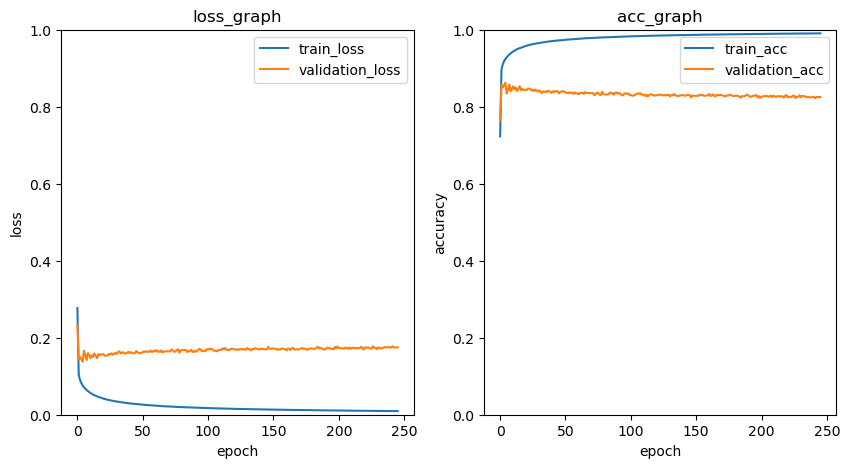

epoch: 247/300 Step: 849 dice_loss : 0.0094 dice_score: 0.9906: 100%|██████████| 848/848 [01:34<00:00,  8.96it/s]
Validation epoch: 247/300 Step: 20 dice_loss : 0.1737  dice_score: 0.8263: 100%|██████████| 19/19 [00:00<00:00, 22.00it/s]
epoch: 248/300 Step: 849 dice_loss : 0.0094 dice_score: 0.9906: 100%|██████████| 848/848 [01:35<00:00,  8.92it/s]
Validation epoch: 248/300 Step: 20 dice_loss : 0.1743  dice_score: 0.8257: 100%|██████████| 19/19 [00:00<00:00, 21.15it/s]
epoch: 249/300 Step: 849 dice_loss : 0.0094 dice_score: 0.9906: 100%|██████████| 848/848 [01:35<00:00,  8.90it/s]
Validation epoch: 249/300 Step: 20 dice_loss : 0.1752  dice_score: 0.8248: 100%|██████████| 19/19 [00:00<00:00, 22.29it/s]
epoch: 250/300 Step: 849 dice_loss : 0.0093 dice_score: 0.9907: 100%|██████████| 848/848 [01:34<00:00,  8.93it/s]
Validation epoch: 250/300 Step: 20 dice_loss : 0.1757  dice_score: 0.8243: 100%|██████████| 19/19 [00:00<00:00, 22.80it/s]
epoch: 251/300 Step: 849 dice_loss : 0.0093 dice_sco

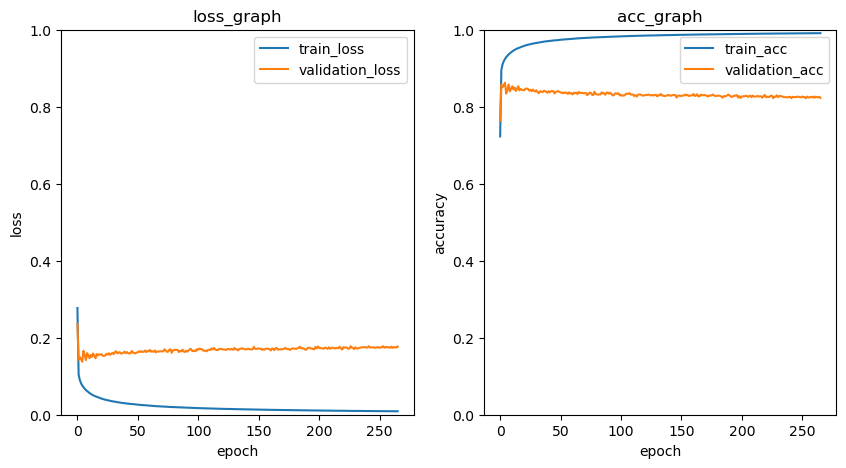

epoch: 267/300 Step: 849 dice_loss : 0.0089 dice_score: 0.9911: 100%|██████████| 848/848 [01:36<00:00,  8.83it/s]
Validation epoch: 267/300 Step: 20 dice_loss : 0.1729  dice_score: 0.8271: 100%|██████████| 19/19 [00:00<00:00, 20.33it/s]
epoch: 268/300 Step: 849 dice_loss : 0.0089 dice_score: 0.9911: 100%|██████████| 848/848 [01:37<00:00,  8.72it/s]
Validation epoch: 268/300 Step: 20 dice_loss : 0.1749  dice_score: 0.8251: 100%|██████████| 19/19 [00:01<00:00, 16.81it/s]
epoch: 269/300 Step: 849 dice_loss : 0.0089 dice_score: 0.9911: 100%|██████████| 848/848 [01:35<00:00,  8.86it/s]
Validation epoch: 269/300 Step: 20 dice_loss : 0.1739  dice_score: 0.8261: 100%|██████████| 19/19 [00:00<00:00, 20.03it/s]
epoch: 270/300 Step: 849 dice_loss : 0.0088 dice_score: 0.9912: 100%|██████████| 848/848 [01:35<00:00,  8.83it/s]
Validation epoch: 270/300 Step: 20 dice_loss : 0.1732  dice_score: 0.8268: 100%|██████████| 19/19 [00:01<00:00, 16.12it/s]
epoch: 271/300 Step: 849 dice_loss : 0.0088 dice_sco

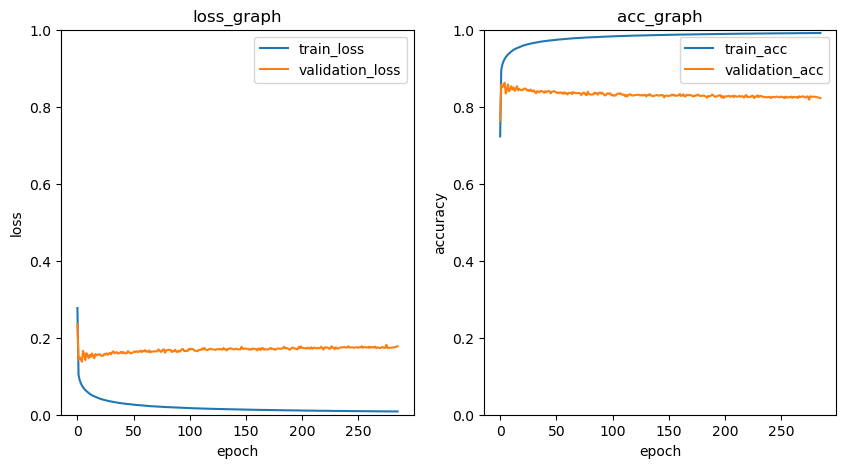

epoch: 287/300 Step: 849 dice_loss : 0.0085 dice_score: 0.9915: 100%|██████████| 848/848 [01:33<00:00,  9.08it/s]
Validation epoch: 287/300 Step: 20 dice_loss : 0.1747  dice_score: 0.8253: 100%|██████████| 19/19 [00:00<00:00, 21.86it/s]
epoch: 288/300 Step: 849 dice_loss : 0.0085 dice_score: 0.9915: 100%|██████████| 848/848 [01:33<00:00,  9.04it/s]
Validation epoch: 288/300 Step: 20 dice_loss : 0.1742  dice_score: 0.8258: 100%|██████████| 19/19 [00:00<00:00, 21.89it/s]
epoch: 289/300 Step: 849 dice_loss : 0.0084 dice_score: 0.9916: 100%|██████████| 848/848 [01:33<00:00,  9.04it/s]
Validation epoch: 289/300 Step: 20 dice_loss : 0.1736  dice_score: 0.8264: 100%|██████████| 19/19 [00:00<00:00, 21.84it/s]
epoch: 290/300 Step: 849 dice_loss : 0.0084 dice_score: 0.9916: 100%|██████████| 848/848 [01:33<00:00,  9.03it/s]
Validation epoch: 290/300 Step: 20 dice_loss : 0.1732  dice_score: 0.8268: 100%|██████████| 19/19 [00:00<00:00, 22.09it/s]
epoch: 291/300 Step: 849 dice_loss : 0.0084 dice_sco

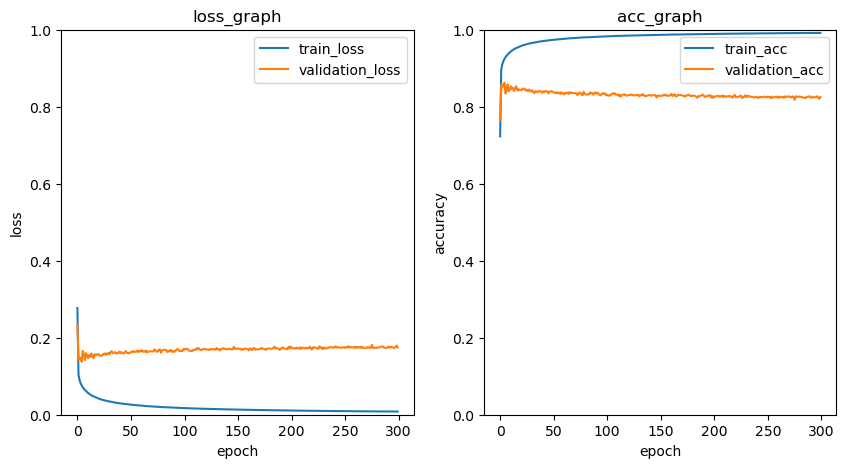

batch size= 4
image size= 224
learning rate= 0.0001


In [ ]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(300):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y,num_classes=3) # cost 구함
        acc=1-dice_loss(predict, y,num_classes=3)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{300} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(validation_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y,num_classes=3) # cost 구함
            acc=1-dice_loss(predict, y,num_classes=3)
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"Validation epoch: {epoch+1}/{300} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/segmentation/NestedUNet_3class_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%20==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 4')
print('image size= 224')
print('learning rate= 0.0001')